/Users/rob/anaconda3/envs/daq/lib/python3.6/site-packages/odo/backends/pandas.py:102: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access NaTType as type(pandas.NaT)
  @convert.register((pd.Timestamp, pd.Timedelta), (pd.tslib.NaTType, type(None)))



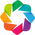

In [1]:
import copy
import numpy as np
import pandas as pd
import holoviews as hv
from daq.pico import CSV
from scipy.optimize import fmin, minimize, basinhopping, fsolve
from easier import ParamState, shade, Item
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge
from harmonic import Harmonic
hv.extension('bokeh')

In [29]:
file_name = './data_20171220/20171220-0003.csv'
# file_name = './data_20171220/20171220-0004.csv'
# file_name = './data_20171220/20171220-0005.csv'
# file_name = './data_20171220/20171220-0001.csv'  # air

fundamental_freq = 20

df_small = CSV(file_name, a='sig_gen', b='res_volt', c='sec_volt', max_sample_freq=500).df

df = CSV(file_name, a='sig_gen', b='res_volt', c='sec_volt', max_sample_freq=3000000).df
df.head()

,t,sig_gen,res_volt,sec_volt
0,-0.00002,0.002228,-0.033641,-0.049516
1,0.00000,0.007538,-0.033308,-0.063891
2,0.00002,0.005432,-0.023276,-0.077700
3,0.00004,0.008667,-0.028428,-0.069079
4,0.00006,0.013489,-0.044166,-0.069247


In [30]:
def refine_fundamental(df, fundamental_freq):
    h = Harmonic(freq=fundamental_freq, num_freqs=1)
    h.refine_frequency(df.t, df.sig_gen)
    return h.f0
    
fundamental_freq = 20
fundamental_freq = refine_fundamental(df_small, fundamental_freq)
fundamental_freq

/Users/rob/anaconda3/envs/daq/lib/python3.6/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


19.976864971249693

# USE SECOND DERIVATIVE TO REGSITER SIGNALS

In [33]:
%%opts Curve [width=400, height=400 show_grid=True tools=['hover']]

alpha=.0001
# alpha=.00001

# h = Harmonic(freq=fundamental_freq, num_freqs=10)
h = Harmonic(freq=fundamental_freq, num_freqs=3)
h_res = h.clone()
h_sec = h.clone()

h_res.fit(df.t, df.res_volt, alpha=alpha)
h_sec.fit(df.t, df.sec_volt, alpha=alpha)

kwargs = dict(
    t=df.t,
    dres=-h_res.derivative().predict(df.t),
    d2res=-h_res.derivative(2).predict(df.t),
    sec=h_sec.predict(df.t - delta),
    dsec=h_sec.derivative().predict(df.t - delta)
)

dff = pd.DataFrame(kwargs, columns=kwargs.keys())
for field in [f for f in dff if f != 't']:
    dff.loc[:, field] = dff.loc[:, field] / dff.loc[:, field].std()
# dff = dff.loc[:, 'res_int': ] / dff.loc[:, 'res_int': ].std()

display(dff.head())



ind = int(np.median(dff.index))
t0 = dff.t.loc[ind]

dfs = dff[(dff.t >= t0) & (dff.t < (t0 +  2 * h.period))]
"""
running ridge
coeff = [  1.28838634e-02  -3.79664937e-05  -9.42967288e-06   5.66581212e-06
  -7.68015317e-06  -3.22833448e-02   3.84998243e-05  -6.69813949e-05
  -1.12696036e-05  -1.35224942e-05]
running ridge
coeff = [ -3.18306729e-01  -1.46547454e-04   1.83099310e-05  -2.93660057e-05
   1.31909574e-07  -6.70682307e-02   5.31044207e-05  -1.61663808e-03
  -4.75333242e-05  -1.02218363e-04]"""

(
#     hv.Curve((dfs.dres, dfs.sec), kdims=['dres_'], vdims=['sec_'])
    hv.Curve((dfs.dres, dfs.dres - dfs.sec), kdims=['dres_'], vdims=['sec_'])
    
    + (
        hv.Curve(dfs, kdims=['t'], vdims=['dres'], label='dres_')
        * hv.Curve(dfs, kdims=['t'], vdims=['sec'], label='sec_')
        * hv.Curve(dfs, kdims=['t'], vdims=['d2res'], label='d2res_')
        * hv.Curve(dfs, kdims=['t'], vdims=['dsec'], label='dsec_')
    )
).cols(1)

running ridge
model Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
coeff = [ 0.01268384 -0.         -0.         -0.03208337  0.         -0.        ]
running ridge
model Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
coeff = [-0.31810794 -0.          0.         -0.06686868  0.         -0.00141642]


,t,dres,d2res,sec,dsec
0,-0.00002,-0.516478,-1.316867,-0.536053,-1.301686
1,0.00000,-0.519780,-1.315565,-0.539317,-1.300229
2,0.00002,-0.523079,-1.314255,-0.542577,-1.298765
3,0.00004,-0.526375,-1.312937,-0.545834,-1.297292
4,0.00006,-0.529667,-1.311611,-0.549087,-1.295812


:Layout
   .Curve.I   :Curve   [dres_]   (sec_)
   .Overlay.I :Overlay
      .Curve.Dres_  :Curve   [t]   (dres)
      .Curve.Sec_   :Curve   [t]   (sec)
      .Curve.D2res_ :Curve   [t]   (d2res)
      .Curve.Dsec_  :Curve   [t]   (dsec)

In [32]:
x0_d2res = fsolve(h_res.derivative(2).predict, 5.039)[0]
x0_dsec = fsolve(h_sec.derivative(1).predict, x0_d2res)[0]
x0_d2res, x0_dsec
delta = x0_d2res - x0_dsec
delta

-0.0014353423019128897

In [17]:
fsolve(h_sec.predict, 5.039)

array([ 5.02912439])

In [18]:
bool(x.shape)

False

In [ ]:
%%opts RGB [width=400, height=400]
%%opts Curve [width=400, height=400]

def register(df, fundamental_freq):

    h = Harmonic(freq=fundamental_freq, num_freqs=5)
    h_res = h.clone()
    h_sec = h.clone()

    h_res.fit(df.t, df.res_volt)
    h_sec.fit(df.t, df.sec_volt)

    h_res_int = h_res.integral()
    kwargs = dict(
        t=df.t,
        res_int=h_res_int.predict(df.t),
        sec=h_sec.predict(df.t + 1 * .00149)
    )

    dff = pd.DataFrame(kwargs, columns=kwargs.keys())
    for field in ['res_int', 'sec']:
        dff.loc[:, field] = dff.loc[:, field] / dff.loc[:, field].std()
    # dff = dff.loc[:, 'res_int': ] / dff.loc[:, 'res_int': ].std()

    display(dff.head())



    ind = int(np.median(dff.index))
    t0 = dff.t.loc[ind]

dfs = dff[(dff.t >= t0) & (dff.t < (t0 +  h.period))]


(
#     hv.Curve((dfs.res_int, dfs.sec), kdims=['res_int_'], vdims=['sec_'])
    hv.Curve((dfs.res_int, dfs.res_int - dfs.sec), kdims=['res_int_'], vdims=['sec_'])
    
    + (
        hv.Curve(dfs, kdims=['t'], vdims=['res_int'])
        * hv.Curve(dfs, kdims=['t'], vdims=['sec'])
    )
)

In [ ]:
h